## Este Notebook es capaz de sacar varios DataFrames, que se diferencian entre si, por las variables (columnas) que poseen.

## Hasta el momento, tenemos 4 posibilidades:


1.   clean_data_all.csv: Data frame con TODAS las variables.
2.   clean_data_genetic.csv: Data frame con las variables seleccionadas por el algoritmo genético que está presente en este Notebook.
1.   clean_data_imp.csv: Data frame con las variables que más importancia tienen desde el punto de vista del negocio.
2.   clean_data_ind.csv: Data frame únicamente con las variables de los indicadores calculados en el Notebook de CalculoIndicadores.ipynb.

##  **En la siguiente celda, debemos seleccionar qué Data Frame queremos que salga como resultado de este Notebook.**



In [ ]:
dfs = ['all', 'genetic', 'imp', 'ind']

id_dfs = 0 # <- Si ponemos 0, se utiliza 'all', si ponemos 1, se utiliza 'genetic', etc.

result_df_name = dfs[id_dfs]

print(f'El Data Frame resultado será: data_clean_{result_df_name}.csv')

El Data Frame resultado será: data_clean_all.csv


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 20 18:44:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!pip install chart_studio
!pip install sklearn-genetic
!pip install fancyimpute

In [ ]:
# Importamos las librerias
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
%matplotlib inline

import missingno

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio.plotly as py

from datetime import datetime

from genetic_selection import GeneticSelectionCV

In [ ]:
# Esta celda sirve para autenticarse con tu cuenta de DRIVE. Al ejecutarla, aparecerá un enlace, inicias sesión y copias el código que te sale.
# A continuación, pegas el código en el campo que aparece aquí abajo.
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Cargamos el dataset
df_orig = pd.read_csv(f"/drive/.shortcut-targets-by-id/1exJXUwwnq3lYO6XPyFBm-TQoTaxjsO2c/TFM MBIT/Data/DataFrameFull.csv") 

In [ ]:
df = df_orig.copy()
df.drop(columns=['Unnamed: 0'], inplace = True)
df

,time,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,sentiment_absolute,sentiment_relative,search_average,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,alt_rank,alt_rank_30d,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,percent_change_24h,market_cap_global,market_dominance,SO,EMA_6,EMA_12,EMA_24,MACD,RSI_21,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,STOCHRSIk_21_21_3_3,STOCHRSId_21_21_3_3,MOM_21,gold,EURUSD
0,1523264400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,30.0,14.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1332.07,1.23236
1,1523268000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,75.0,40.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1332.14,1.23113
2,1523271600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,40.0,59.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1333.30,1.23188
3,1523275200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,63.0,77.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1335.16,1.23182
4,1523278800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,82.0,85.0,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1335.67,1.23174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27727,1626408000,31955.771162,31943.856539,32040.245094,31898.221292,9.583896e+08,5.998500e+11,1449.0,760.0,40.0,169.0,89.0,266.0,7297.0,3560.0,33242607.0,70.0,1062.0,347.0,4290.0,200.0,677.0,968.0,5091.0,361.0,760302.0,3125325.0,2169036.0,19599582.0,7594131.0,33250260.0,3.6,3.0,86.0,NaN,11.0,3.3,4.1,2.8,69.0,0.015417,107.0,46.0,1.0,1529.0,2.0,1.0,1.0,NaN,NaN,7181.0,8197,1.0,34989.0,23.427363,-2.356416,1.449605e+12,41.380241,85.140804,31887.625972,31866.259551,31973.663948,-107.404396,45.899131,31358.217367,31814.957588,32271.697810,95.673567,87.282445,-566.109934,1826.24,1.18080
27728,1626411600,31963.102758,31850.888552,31982.958414,31788.240008,8.773209e+08,5.977096e+11,2029.0,744.0,53.0,166.0,54.0,96.0,7918.0,3049.0,28097459.0,237.0,1029.0,482.0,3573.0,201.0,630.0,865.0,5962.0,260.0,594042.0,3807854.0,1762111.0,18912798.0,3025975.0,28105071.0,3.7,3.0,88.0,NaN,15.0,2.8,4.1,2.7,66.5,0.015380,94.0,48.0,1.0,1489.0,2.0,1.0,1.0,NaN,NaN,7514.0,8784,1.0,37873.0,23.193304,-2.330319,1.449593e+12,41.232919,73.957123,31877.129566,31863.894782,31963.841916,-99.947134,44.232140,31461.228781,31781.049533,32100.870284,91.920788,92.588953,-544.477312,1824.53

# Exploratory Data Analysis

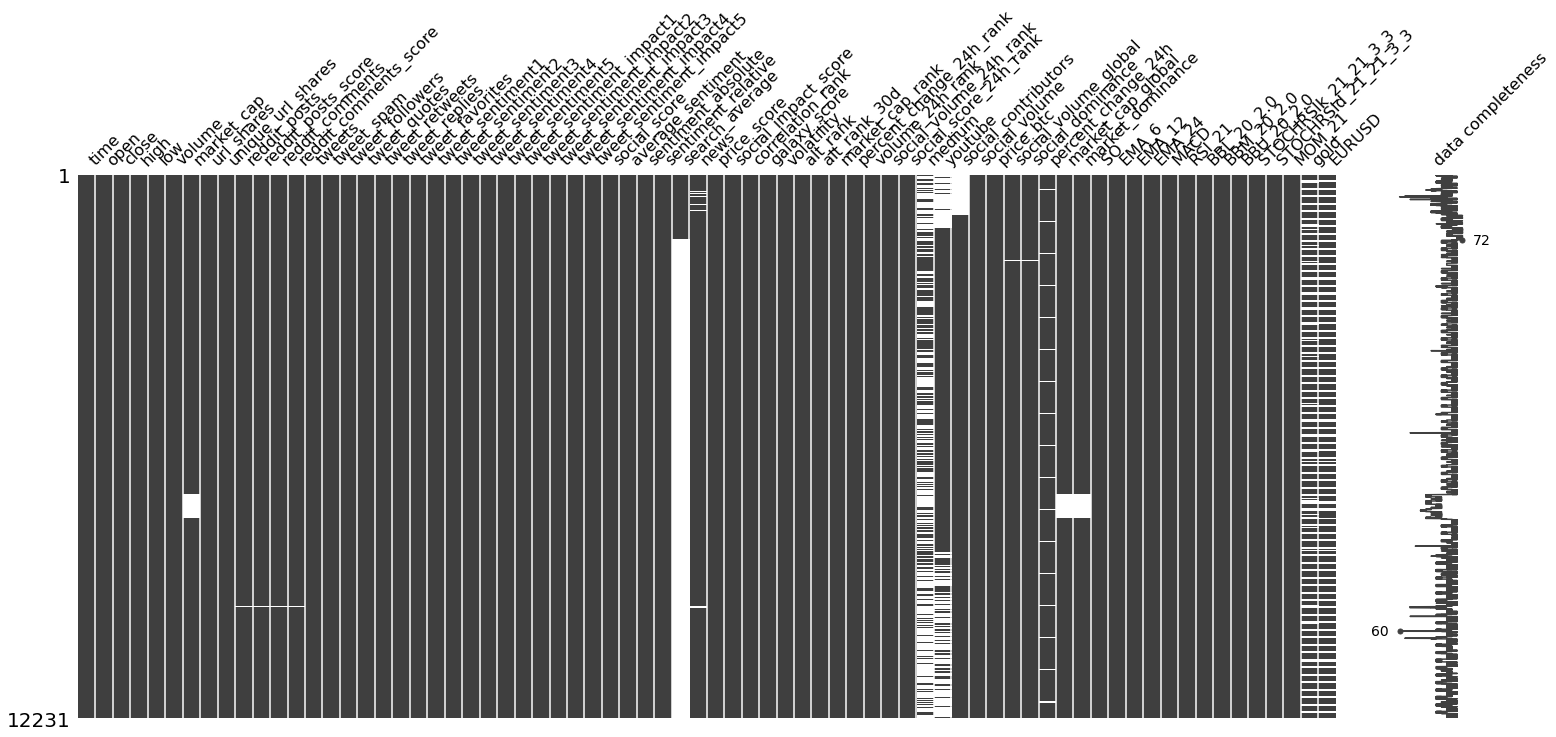

In [ ]:
missingno.matrix(df.loc[15501:], labels=True);

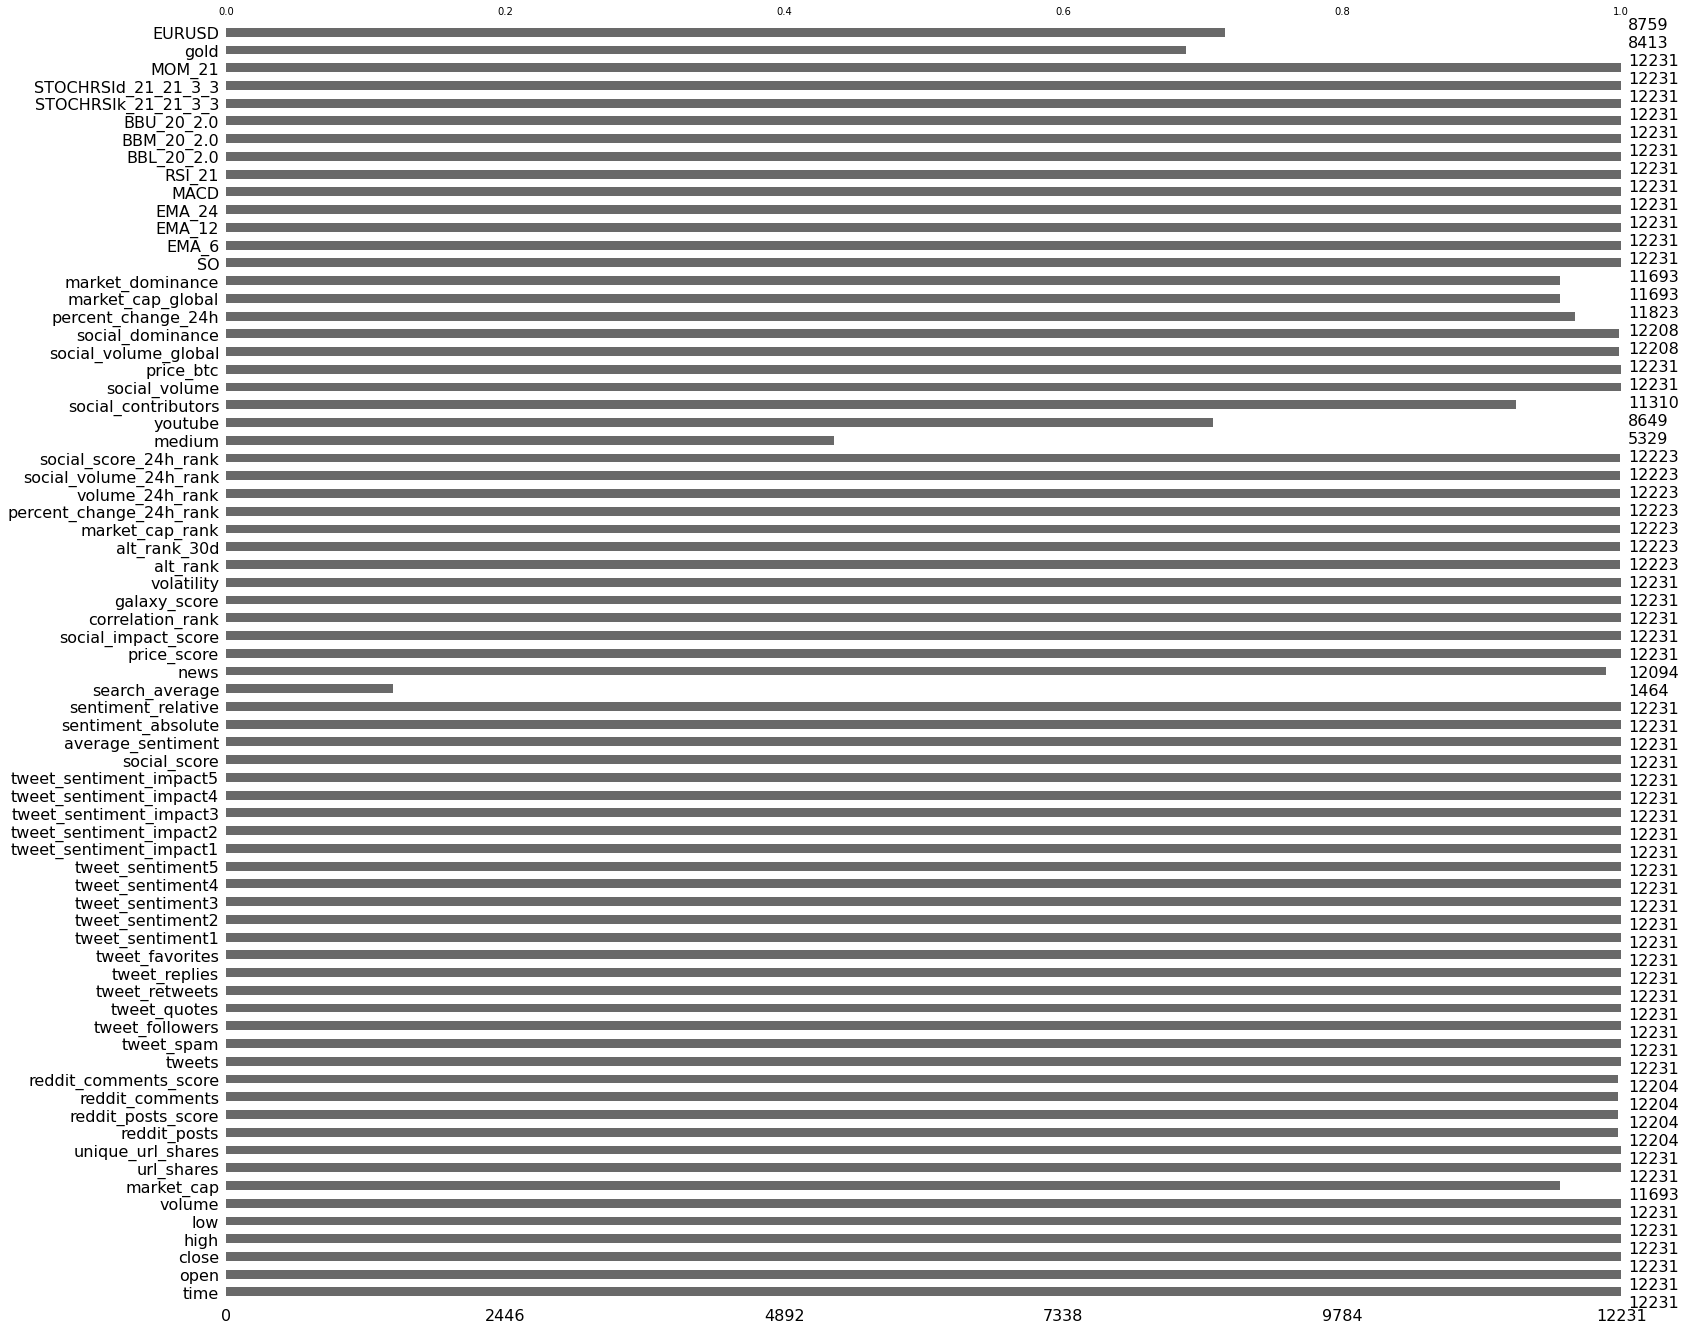

In [ ]:
missingno.bar(df.loc[15501:]);

In [ ]:
#Seleccionamos los registros a partir de la línea que tiene todas las variables completas y no hay nul
df = df.loc[15501:]

In [ ]:
df

,time,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,sentiment_absolute,sentiment_relative,search_average,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,alt_rank,alt_rank_30d,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,percent_change_24h,market_cap_global,market_dominance,SO,EMA_6,EMA_12,EMA_24,MACD,RSI_21,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,STOCHRSIk_21_21_3_3,STOCHRSId_21_21_3_3,MOM_21,gold,EURUSD
15501,1582394400,9719.735206,9735.570696,9735.570696,9719.735206,9.312383e+08,1.767503e+11,1012.0,564.0,29.0,333.0,50.0,166.0,3537.0,597.0,15016944.0,55.0,634.0,211.0,2089.0,81.0,270.0,653.0,2337.0,196.0,477943.0,406519.0,2255757.0,11193218.0,686496.0,15021296.0,3.6,3.0,88.0,0.0,30.0,4.7,3.6,3.9,79.0,0.005421,14.0,1.0,1.0,624.0,2.0,1.0,1.0,NaN,NaN,NaN,4210,1.0,11656.0,36.118737,-0.213372,2.808393e+11,62.936451,98.165244,9696.256419,9677.495991,9677.068194,0.427797,53.831972,9557.501297,9664.781641,9772.061985,100.000000,82.178635,22.929442,NaN,NaN
15502,1582398000,9708.042429,9729.889076,9729.889076,9708.042429,9.683068e+08,1.769025e+11,839.0,582.0,28.0,227.0,58.0,265.0,3011.0,476.0,14604305.0,28.0,574.0,220.0,1480.0,83.0,144.0,621.0,1964.0,199.0,1401173.0,984354.0,2183365.0,9359625.0,678090.0,14607772.0,3.7,3.0,91.0,0.0,24.0,3.4,3.6,3.7,72.0,0.005453,26.0,1.0,1.0,752.0,2.0,1.0,1.0,3.0,NaN,NaN,3703,1.0,10573.0,35.023172,0.269196,2.805242e+11,63.061411,95.304213,9705.865750,9685.556465,9681.293865,4.262601,53.307795,9560.130072,9663.465818,9766.801563,98.621214,92.924929,-3.783582,NaN,NaN
15503,1582401600,9767.448508,9758.317327,9767.448508,9758.317327,9.858664e+08,1.770860e+11,805.0,489.0,22.0,155.0,63.0,136.0,2829.0,499.0,8903297.0,46.0,870.0,253.0,2034.0,115.0,165.0,522.0,1883.0,144.0,792628.0,1211868.0,1842846.0,4729903.0,329255.0,8907489.0,3.6,3.0,88.0,0.0,25.0,3.2,3.6,3.8,71.0,0.005545,42.0,1.0,1.0,829.0,2.0,1.0,1.0,1.0,NaN,NaN,3428,1.0,10550.0,32.492891,0.262166,2.813069e+11,62.951165,109.619514,9720.851915,9696.750444,9687.455742,9.294702,55.580178,9561.029459,9663.147291,9765.265123,98.621214,99.080810,2.111785,NaN,NaN
15504,1582405200,9797.299588,9773.401393,9797.299588,9773.401393,9.616952e+08,1.771181e+11,781.0,470.0,17.0,47.0,44.0,137.0,2998.0,421.0,11477965.0,74.0,1174.0,825.0,2904.0,72.0,198.0,487.0,2050.0,191.0,268902.0,402372.0,2115390.0,6787231.0,1909047.0,11483853.0,3.7,3.0,89.0,0.0,26.0,3.2,3.0,3.6,67.5,0.005697,46.0,1.0,1.0,870.0,2.0,1.0,1.0,NaN,NaN,NaN,3555,1.0,9521.0,37.338515,0.625578,2.820410e+11,62.798698,103.216021,9735.866051,9708.542898,9694.331394,14.211504,56.752786,9555.911326,9665.396593,9774.881861,98.621214,98.621214,8.713528,NaN,NaN
15505,1582408800,9757.102434,9758.065483,9758.065483,9757.102434,9.058356e+08,1.770504e+11,659.0,418.0,32.0,305.0,40.0,140.0,2845.0,436.0,9885030.0,28.0,361.0,227.0,1511.0,62.0,118.0,548.0,1921.0,196.0,322557.0,476541.0,2638618.0,5796316.0,653125.0,9888089.0,3.7,3.0,92.0,0.0,20.0,3.0,3.0,3.6,66.5,0.005791,45.0,1.0,1.0,829.0,2.0,1.0,1.0,NaN,1.0,NaN,3355,1.0,9223.0,36.376450,0.250602,2.815754e+11,62.878510,81.747505,9742.208746,9716.161757,9699.430121,16.731636,55.197271,9552.532655,9669.030826,9785.528998,96.674810,97.972413,29.650139,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
#ponemos la columna time como index
df.set_index('time', inplace=True)

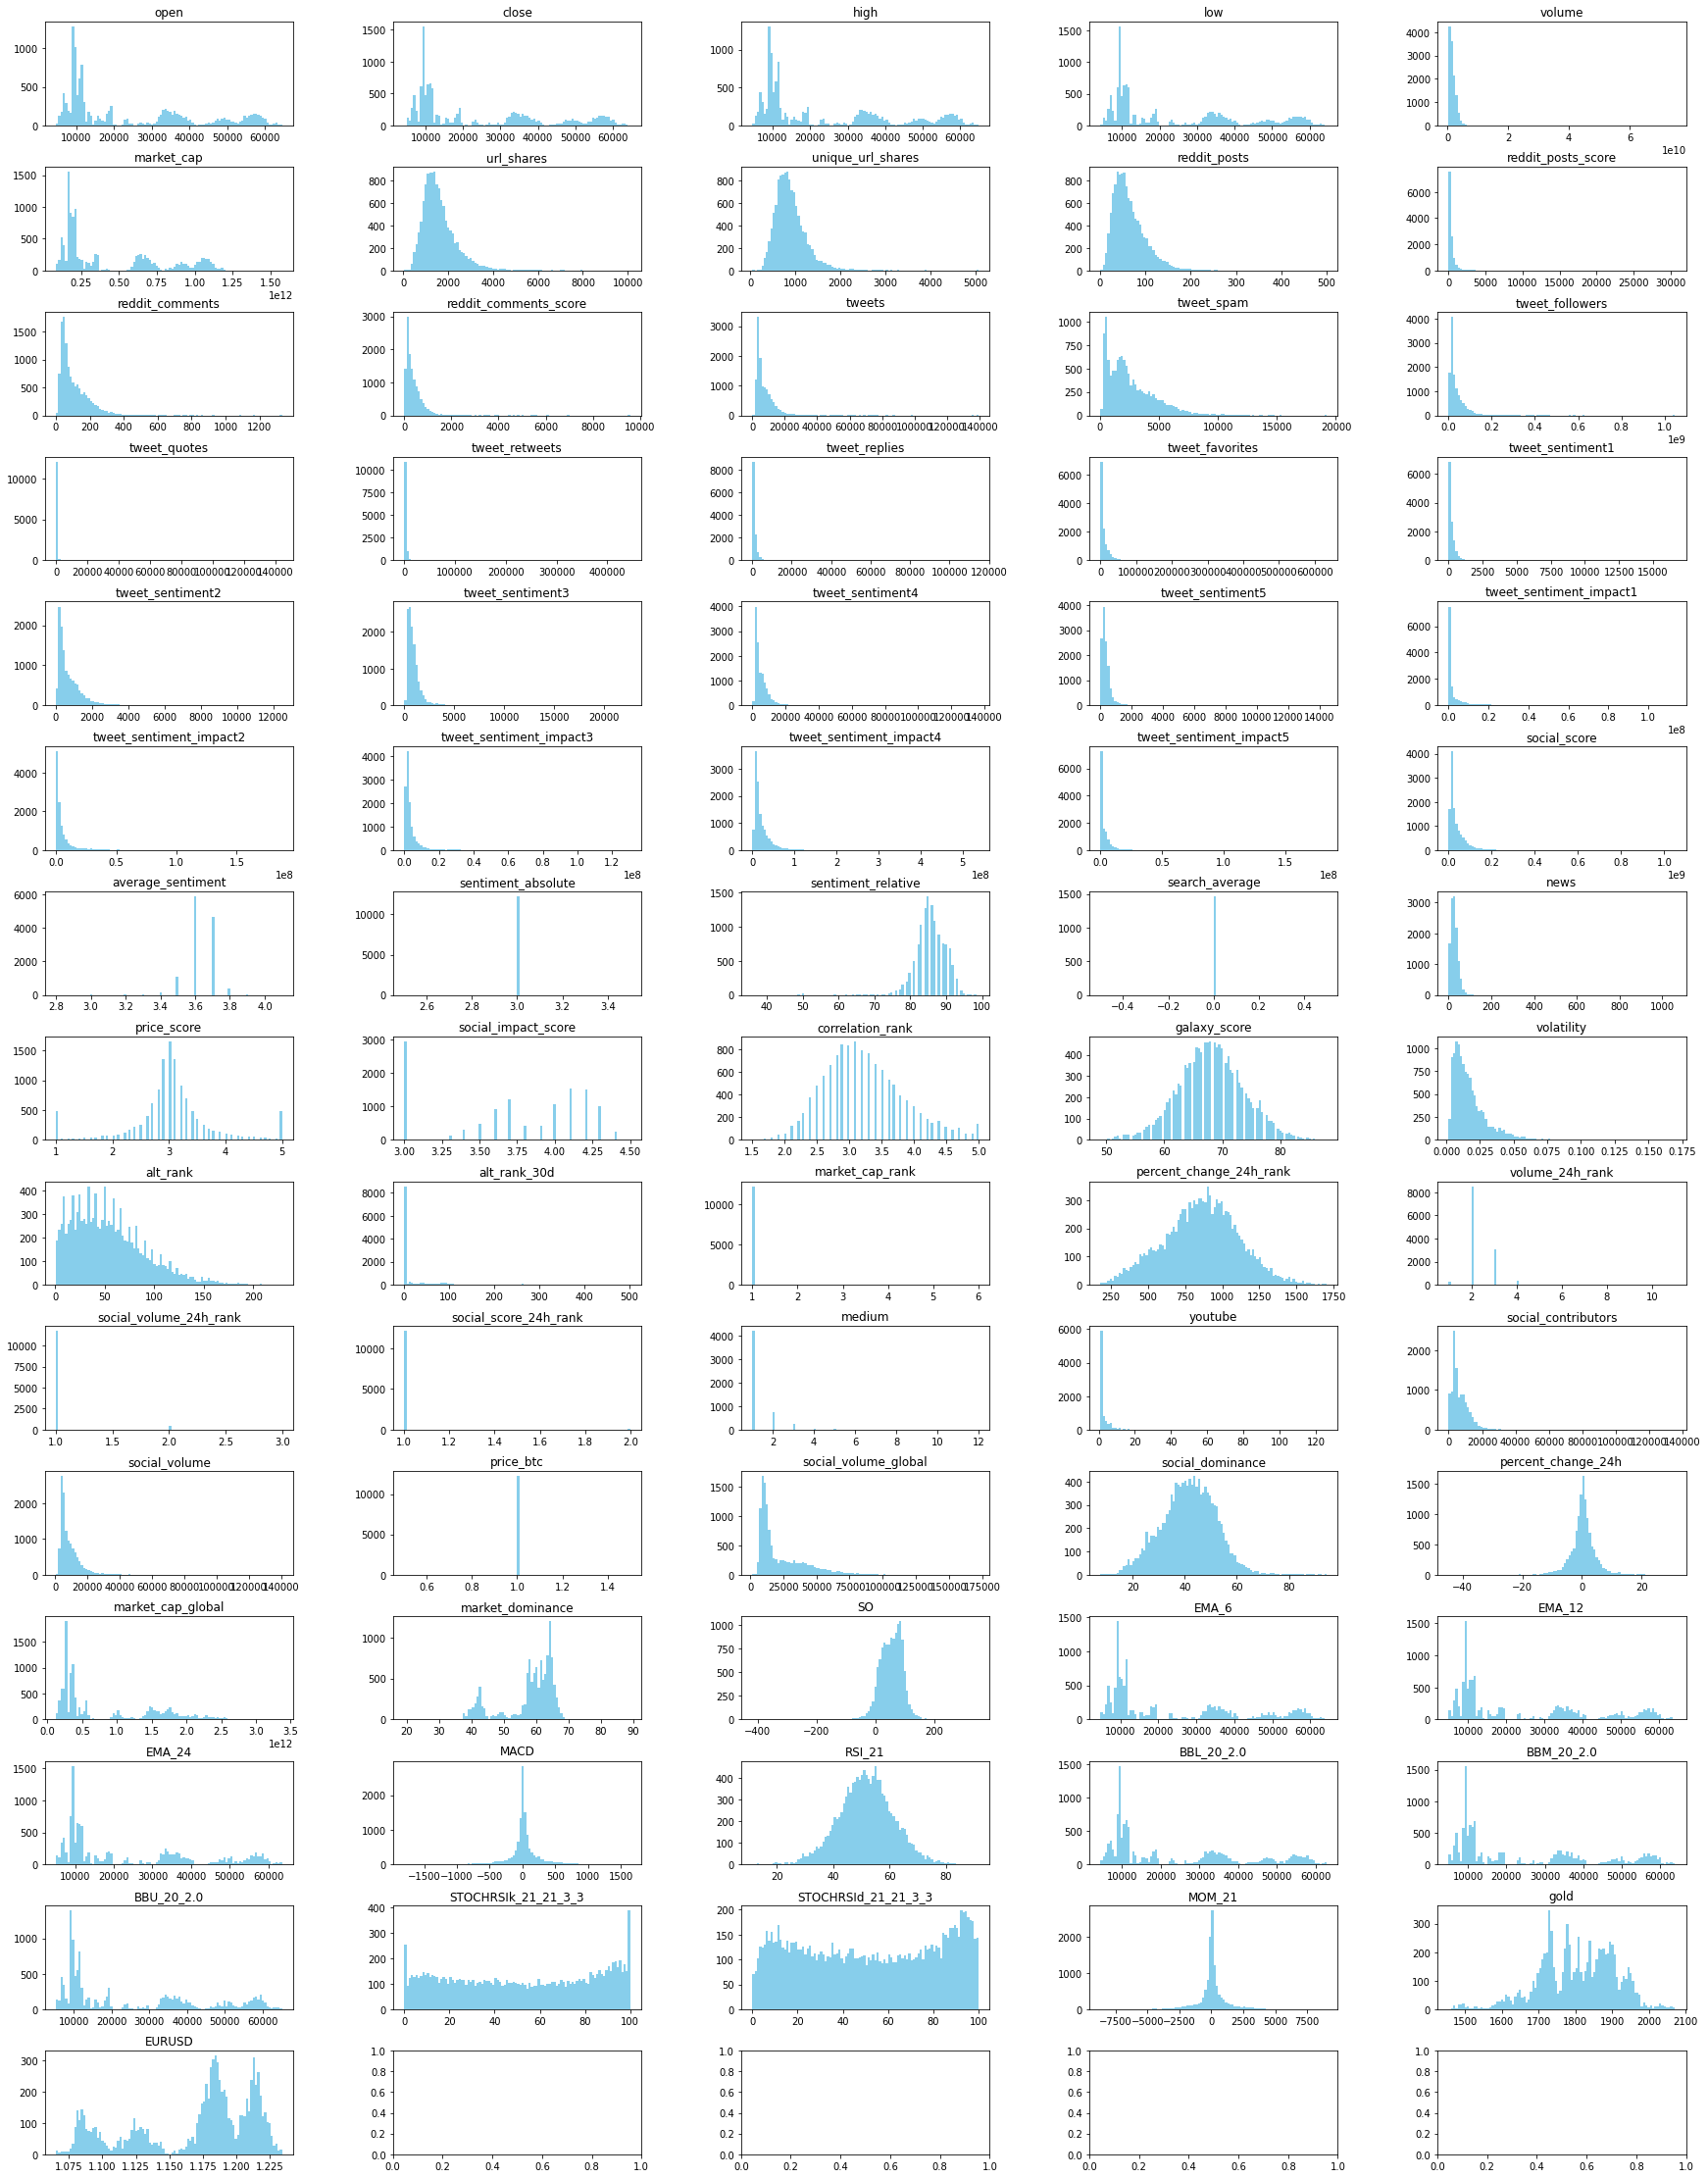

In [ ]:
fig_rows = int(df.shape[1]/5) + 1
fig, ax = plt.subplots(fig_rows, 5, figsize=(30, 40))
k = 0
for i in range(fig_rows):
  for j in range(5):
    if k < df.shape[1]:
      ax[i, j].hist(df.iloc[:, k], color = 'skyblue', bins = 100)
      ax[i, j].set_title(df.columns[k])
      k += 1

fig.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
df

,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,sentiment_absolute,sentiment_relative,search_average,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,alt_rank,alt_rank_30d,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,percent_change_24h,market_cap_global,market_dominance,SO,EMA_6,EMA_12,EMA_24,MACD,RSI_21,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,STOCHRSIk_21_21_3_3,STOCHRSId_21_21_3_3,MOM_21,gold,EURUSD
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1582394400,9719.735206,9735.570696,9735.570696,9719.735206,9.312383e+08,1.767503e+11,1012.0,564.0,29.0,333.0,50.0,166.0,3537.0,597.0,15016944.0,55.0,634.0,211.0,2089.0,81.0,270.0,653.0,2337.0,196.0,477943.0,406519.0,2255757.0,11193218.0,686496.0,15021296.0,3.6,3.0,88.0,0.0,30.0,4.7,3.6,3.9,79.0,0.005421,14.0,1.0,1.0,624.0,2.0,1.0,1.0,NaN,NaN,NaN,4210,1.0,11656.0,36.118737,-0.213372,2.808393e+11,62.936451,98.165244,9696.256419,9677.495991,9677.068194,0.427797,53.831972,9557.501297,9664.781641,9772.061985,100.000000,82.178635,22.929442,NaN,NaN
1582398000,9708.042429,9729.889076,9729.889076,9708.042429,9.683068e+08,1.769025e+11,839.0,582.0,28.0,227.0,58.0,265.0,3011.0,476.0,14604305.0,28.0,574.0,220.0,1480.0,83.0,144.0,621.0,1964.0,199.0,1401173.0,984354.0,2183365.0,9359625.0,678090.0,14607772.0,3.7,3.0,91.0,0.0,24.0,3.4,3.6,3.7,72.0,0.005453,26.0,1.0,1.0,752.0,2.0,1.0,1.0,3.0,NaN,NaN,3703,1.0,10573.0,35.023172,0.269196,2.805242e+11,63.061411,95.304213,9705.865750,9685.556465,9681.293865,4.262601,53.307795,9560.130072,9663.465818,9766.801563,98.621214,92.924929,-3.783582,NaN,NaN
1582401600,9767.448508,9758.317327,9767.448508,9758.317327,9.858664e+08,1.770860e+11,805.0,489.0,22.0,155.0,63.0,136.0,2829.0,499.0,8903297.0,46.0,870.0,253.0,2034.0,115.0,165.0,522.0,1883.0,144.0,792628.0,1211868.0,1842846.0,4729903.0,329255.0,8907489.0,3.6,3.0,88.0,0.0,25.0,3.2,3.6,3.8,71.0,0.005545,42.0,1.0,1.0,829.0,2.0,1.0,1.0,1.0,NaN,NaN,3428,1.0,10550.0,32.492891,0.262166,2.813069e+11,62.951165,109.619514,9720.851915,9696.750444,9687.455742,9.294702,55.580178,9561.029459,9663.147291,9765.265123,98.621214,99.080810,2.111785,NaN,NaN
1582405200,9797.299588,9773.401393,9797.299588,9773.401393,9.616952e+08,1.771181e+11,781.0,470.0,17.0,47.0,44.0,137.0,2998.0,421.0,11477965.0,74.0,1174.0,825.0,2904.0,72.0,198.0,487.0,2050.0,191.0,268902.0,402372.0,2115390.0,6787231.0,1909047.0,11483853.0,3.7,3.0,89.0,0.0,26.0,3.2,3.0,3.6,67.5,0.005697,46.0,1.0,1.0,870.0,2.0,1.0,1.0,NaN,NaN,NaN,3555,1.0,9521.0,37.338515,0.625578,2.820410e+11,62.798698,103.216021,9735.866051,9708.542898,9694.331394,14.211504,56.752786,9555.911326,9665.396593,9774.881861,98.621214,98.621214,8.713528,NaN,NaN
1582408800,9757.102434,9758.065483,9758.065483,9757.102434,9.058356e+08,1.770504e+11,659.0,418.0,32.0,305.0,40.0,140.0,2845.0,436.0,9885030.0,28.0,361.0,227.0,1511.0,62.0,118.0,548.0,1921.0,196.0,322557.0,476541.0,2638618.0,5796316.0,653125.0,9888089.0,3.7,3.0,92.0,0.0,20.0,3.0,3.0,3.6,66.5,0.005791,45.0,1.0,1.0,829.0,2.0,1.0,1.0,NaN,1.0,NaN,3355,1.0,9223.0,36.376450,0.250602,2.815754e+11,62.878510,81.747505,9742.208746,9716.161757,9699.430121,16.731636,55.197271,9552.532655,9669.030826,9785.528998,96.674810,97.972413,29.650139,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# eliminamos las columnas para evitar la colinealidad con el precio (cierre)
df.drop(columns = ['high', 'low', 'open'], inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



IMPUTACIÓN DE NULOS

In [ ]:
#imputamos los nul con KNN usando k=3 (cremaos función para hacer la imputación)
from fancyimpute import KNN
from fancyimpute import SimpleFill
def imputeFancyDF(data, strat):
    if strat=='knn':
        df_imp=KNN(k=3, verbose=False).fit_transform(data)
    elif strat=='random':
        df_imp=SimpleFill(fill_method='random').fit_transform(data)
    df_imp=pd.DataFrame(df_imp)
    df_imp.columns=data.columns
    df_imp.index=data.index
    return(df_imp)

In [ ]:
#guardamos el df completo
df = imputeFancyDF(df, 'knn')

TRAIN-TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['close']), df['close'], test_size = 0.1, shuffle = False)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((11007, 67), (11007,), (1224, 67), (1224,))

NORMALIZACIÓN

In [ ]:
from sklearn import preprocessing

def transform(df):
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    if type(df) != pd.core.frame.DataFrame:
        df = pd.DataFrame(df)
    df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df), columns = df.columns, index = df.index)
    min_ = min_max_scaler.data_min_
    max_ = min_max_scaler.data_max_
    return df_scaled, min_max_scaler

def inverse_transform(df_scaled, min_max_scaler):
    if type(df_scaled) != pd.core.frame.DataFrame:
        df_scaled = pd.DataFrame(df_scaled)
    df = pd.DataFrame(min_max_scaler.inverse_transform(df_scaled), columns = df_scaled.columns, index = df_scaled.index)
    return df

In [ ]:
# Para escalar, llamamos a la funcion transform(df), tal que así: X_train, min_max_scaler_X_train = transform(X_train)

# Para deshacer el cambio: X_train = inverse_transform(X_train, min_max_scaler_X_train)

X_train, min_max_scaler_X_train = transform(X_train)
Y_train, min_max_scaler_Y_train = transform(Y_train)
X_test, min_max_scaler_X_test = transform(X_test)
Y_test, min_max_scaler_Y_test = transform(Y_test)

Y_train = Y_train['close']
Y_test = Y_test['close']

X_train.head()

,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,sentiment_absolute,sentiment_relative,search_average,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,alt_rank,alt_rank_30d,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,percent_change_24h,market_cap_global,market_dominance,SO,EMA_6,EMA_12,EMA_24,MACD,RSI_21,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,STOCHRSIk_21_21_3_3,STOCHRSId_21_21_3_3,MOM_21,gold,EURUSD
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1582394400,0.007050,0.062181,0.095835,0.103263,0.056112,0.010865,0.036787,0.017225,0.023890,0.029159,0.013425,0.000361,0.001352,0.001631,0.002889,0.004643,0.020777,0.027930,0.016131,0.013092,0.004218,0.002154,0.016245,0.020298,0.003598,0.014329,0.615385,0.0,0.825397,0.0,0.027436,0.925,0.4,0.685714,0.769231,0.021643,0.057018,1.671446e-10,1.407358e-08,0.327917,0.1,3.518395e-08,7.036789e-08,6.331804e-09,6.278003e-10,0.030059,0.025657,0.0,0.059147,0.328135,0.587026,0.048694,0.540916,0.671530,0.082168,0.079988,0.078900,0.523635,0.529522,0.088227,0.079760,0.074619,1.000000,0.821786,0.491722,0.703689,0.935234
1582398000,0.007548,0.062283,0.078636,0.106844,0.054108,0.007396,0.042793,0.027560,0.020104,0.022847,0.013031,0.000173,0.001217,0.001709,0.001926,0.004763,0.010669,0.026512,0.013391,0.013300,0.012376,0.005235,0.015690,0.016887,0.003553,0.013934,0.692308,0.0,0.873016,0.0,0.021760,0.600,0.4,0.628571,0.589744,0.021837,0.109649,1.671446e-10,1.407358e-08,0.422452,0.1,3.518395e-08,7.036789e-08,1.818182e-01,1.243208e-09,0.030038,0.022030,0.0,0.052802,0.315520,0.593395,0.048597,0.543110,0.667806,0.082330,0.080125,0.078972,0.524748,0.522991,0.088272,0.079738,0.074531,0.986212,0.929249,0.490211,0.703607,0.935175
1582401600,0.007784,0.062406,0.075256,0.088341,0.042084,0.005040,0.046547,0.014093,0.018794,0.024047,0.007584,0.000298,0.001882,0.001997,0.002802,0.006693,0.012354,0.022123,0.012796,0.009490,0.006999,0.006447,0.013076,0.008273,0.001654,0.008497,0.615385,0.0,0.825397,0.0,0.022706,0.550,0.4,0.657143,0.564103,0.022384,0.179825,1.671446e-10,1.407358e-08,0.479321,0.1,3.518395e-08,7.036789e-08,8.816685e-09,9.830932e-10,0.029562,0.020063,0.0,0.052668,0.286384,0.593302,0.048837,0.541174,0.686440,0.082582,0.080314,0.079077,0.526208,0.551302,0.088287,0.079732,0.074506,0.986212,0.990808,0.490544,0.703518,0.935122
1582405200,0.007459,0.062427,0.072870,0.084560,0.032064,0.001505,0.032282,0.014198,0.020010,0.019978,0.010044,0.000492,0.002565,0.006986,0.004176,0.004100,0.015001,0.020571,0.014023,0.012746,0.002371,0.002132,0.015168,0.012101,0.010252,0.010954,0.692308,0.0,0.841270,0.0,0.023652,0.550,0.0,0.600000,0.474359,0.023293,0.197368,1.671446e-10,1.407358e-08,0.509601,0.1,3.518395e-08,7.036789e-08,6.218081e-09,1.013272e-09,0.029908,0.020972,0.0,0.046639,0.342181,0.598098,0.049063,0.538498,0.678105,0.082834,0.080514,0.079195,0.527635,0.565912,0.088199,0.079770,0.074666,0.986212,0.986212,0.490918,0.703619,0.935099
1582408800,0.006709,0.062382,0.060742,0.074214,0.062124,0.009948,0.029279,0.014511,0.018909,0.020761,0.008522,0.000173,0.000739,0.001770,0.001975,0.003497,0.008583,0.023275,0.013075,0.013092,0.002845,0.002528,0.019183,0.010257,0.003417,0.009432,0.692308,0.0,0.888889,0.0,0.017975,0.500,0.0,0.600000,0.448718,0.023852,0.192982,1.671446e-10,1.407358e-08,0.479321,0.1,3.518395e-08,7.036789e-08,1.072437e-08,6.278003e-10,0.030015,0.019541,0.0,0.044893,0.331103,0.593149,0.048920,0.539899,0.650160,0.082941,0.080643

IMPORTANCIA DE VARIABLES 

RF FEATURE IMP

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100,
                           verbose = 1,
                           max_features = 9)

In [ ]:
rf.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished


RandomForestRegressor(max_features=9, verbose=1)

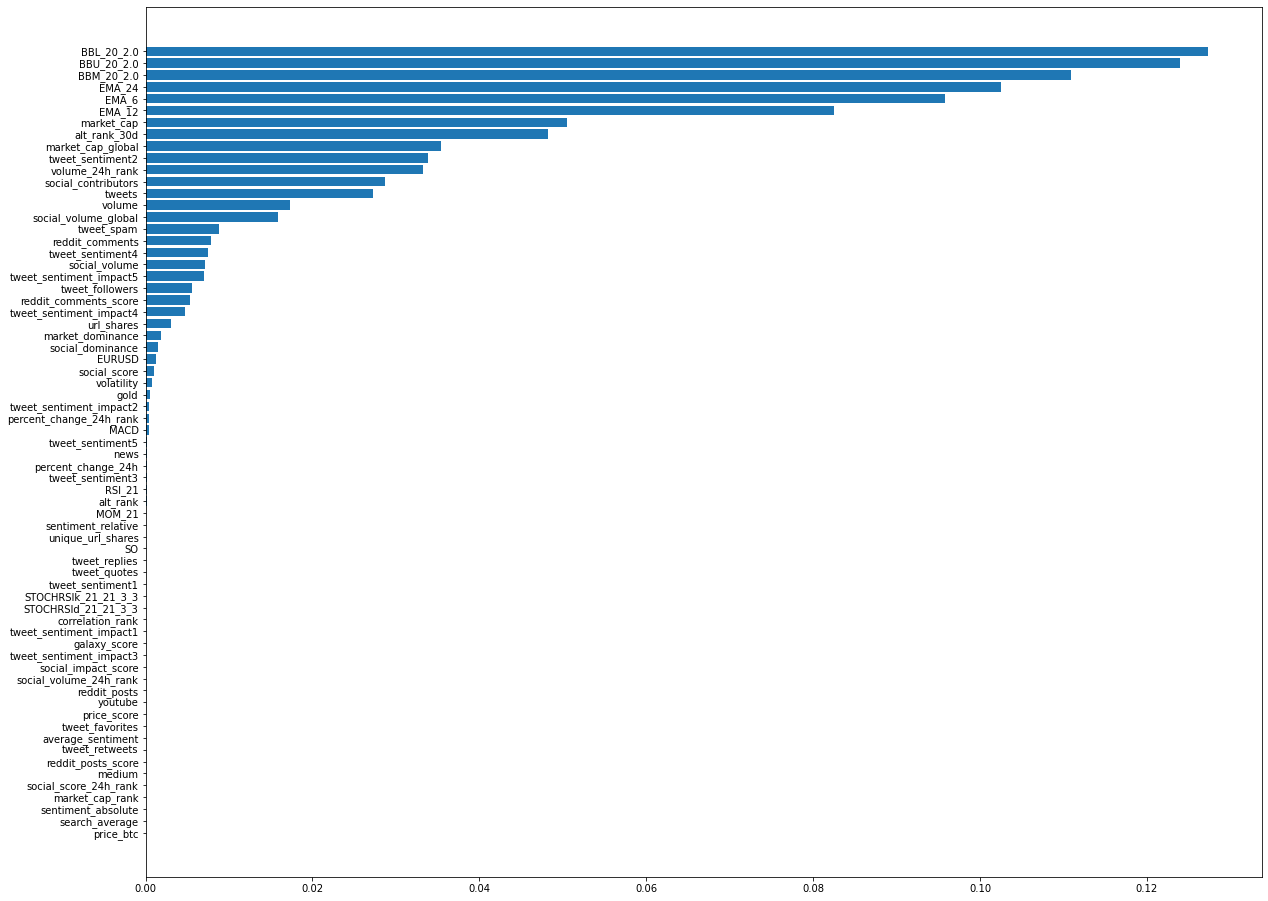

In [ ]:
# visualizamos la importancia de las variables
random = pd.DataFrame(rf.feature_importances_).set_index(X_train.columns)
random.sort_values(0, inplace=True)
fig, ax = plt.subplots(figsize = (20, 16))
ax.barh(y = range(X_train.shape[1]), width = random[0])
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(random[0].index)
plt.show();

REGRESIÓN LINEAL (COEFICIENTES RL)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

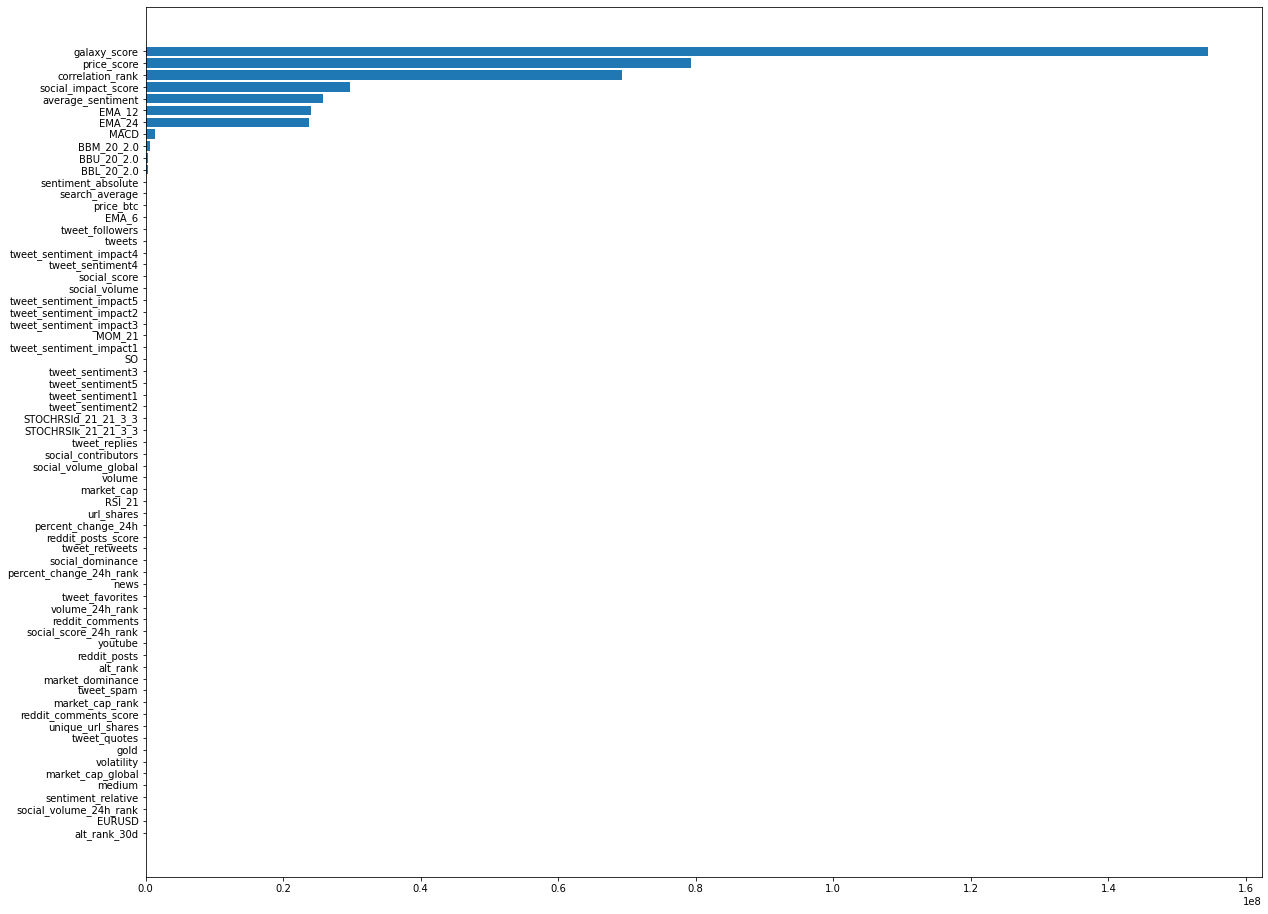

In [ ]:
#Visualizamos el valor de los coef en valor absoluto
random = pd.DataFrame(lr.coef_).set_index(X_train.columns)
random=np.abs(random)
random.sort_values(0, inplace=True)
fig, ax = plt.subplots(figsize = (20, 16))
ax.barh(y = range(X_train.shape[1]), width = random[0])
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(random[0].index)
plt.show();

# Algoritmo genético

In [ ]:
df

,close,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,sentiment_absolute,sentiment_relative,search_average,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,alt_rank,alt_rank_30d,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,percent_change_24h,market_cap_global,market_dominance,SO,EMA_6,EMA_12,EMA_24,MACD,RSI_21,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,STOCHRSIk_21_21_3_3,STOCHRSId_21_21_3_3,MOM_21,gold,EURUSD
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1582394400,9735.570696,9.312383e+08,1.767503e+11,1012.0,564.0,29.0,333.0,50.0,166.0,3537.0,597.0,15016944.0,55.0,634.0,211.0,2089.0,81.0,270.0,653.0,2337.0,196.0,477943.0,406519.0,2255757.0,11193218.0,686496.0,15021296.0,3.6,3.0,88.0,0.0,30.0,4.7,3.6,3.9,79.0,0.005421,14.0,1.0,1.0,624.0,2.0,1.0,1.0,1.0,1.0,4074.421294,4210.0,1.0,11656.0,36.118737,-0.213372,2.808393e+11,62.936451,98.165244,9696.256419,9677.495991,9677.068194,0.427797,53.831972,9557.501297,9664.781641,9772.061985,100.000000,82.178635,22.929442,1887.989207,1.223093
1582398000,9729.889076,9.683068e+08,1.769025e+11,839.0,582.0,28.0,227.0,58.0,265.0,3011.0,476.0,14604305.0,28.0,574.0,220.0,1480.0,83.0,144.0,621.0,1964.0,199.0,1401173.0,984354.0,2183365.0,9359625.0,678090.0,14607772.0,3.7,3.0,91.0,0.0,24.0,3.4,3.6,3.7,72.0,0.005453,26.0,1.0,1.0,752.0,2.0,1.0,1.0,3.0,1.0,4071.568559,3703.0,1.0,10573.0,35.023172,0.269196,2.805242e+11,63.061411,95.304213,9705.865750,9685.556465,9681.293865,4.262601,53.307795,9560.130072,9663.465818,9766.801563,98.621214,92.924929,-3.783582,1887.938812,1.223083
1582401600,9758.317327,9.858664e+08,1.770860e+11,805.0,489.0,22.0,155.0,63.0,136.0,2829.0,499.0,8903297.0,46.0,870.0,253.0,2034.0,115.0,165.0,522.0,1883.0,144.0,792628.0,1211868.0,1842846.0,4729903.0,329255.0,8907489.0,3.6,3.0,88.0,0.0,25.0,3.2,3.6,3.8,71.0,0.005545,42.0,1.0,1.0,829.0,2.0,1.0,1.0,1.0,1.0,4007.213645,3428.0,1.0,10550.0,32.492891,0.262166,2.813069e+11,62.951165,109.619514,9720.851915,9696.750444,9687.455742,9.294702,55.580178,9561.029459,9663.147291,9765.265123,98.621214,99.080810,2.111785,1887.884084,1.223074
1582405200,9773.401393,9.616952e+08,1.771181e+11,781.0,470.0,17.0,47.0,44.0,137.0,2998.0,421.0,11477965.0,74.0,1174.0,825.0,2904.0,72.0,198.0,487.0,2050.0,191.0,268902.0,402372.0,2115390.0,6787231.0,1909047.0,11483853.0,3.7,3.0,89.0,0.0,26.0,3.2,3.0,3.6,67.5,0.005697,46.0,1.0,1.0,870.0,2.0,1.0,1.0,1.0,1.0,4054.010004,3555.0,1.0,9521.0,37.338515,0.625578,2.820410e+11,62.798698,103.216021,9735.866051,9708.542898,9694.331394,14.211504,56.752786,9555.911326,9665.396593,9774.881861,98.621214,98.621214,8.713528,1887.945955,1.223070
1582408800,9758.065483,9.058356e+08,1.770504e+11,659.0,418.0,32.0,305.0,40.0,140.0,2845.0,436.0,9885030.0,28.0,361.0,227.0,1511.0,62.0,118.0,548.0,1921.0,196.0,322557.0,476541.0,2638618.0,5796316.0,653125.0,9888089.0,3.7,3.0,92.0,0.0,20.0,3.0,3.0,3.6,66.5,0.005791,45.0,1.0,1.0,829.0,2.0,1.0,1.0,1.0,1.0,4068.494550,3355.0,1.0,9223.0,36.376450,0.250602,2.815754e+11,62.878510,81.747505,9742.208746,9716.161757,9699.430121,16.731636,55.197271,9552.532655,9669.030826,9785.528998,96.674810,97.972413,29.650139,1887.985619,1.223118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16264080

In [ ]:
if result_df_name == 'imp':
  # Filtramos el DF sólo con las variables que considero + relevantes en base al algortimo genético y sentido de negocio.
  df = df[['close', 'volume', 'market_cap', 'reddit_posts', 'reddit_comments', 'reddit_posts_score', 'reddit_comments_score', 'tweets', 'tweet_followers', 'tweet_retweets', 
          'tweet_favorites', 'tweet_sentiment1', 'tweet_sentiment2', 'tweet_sentiment3', 'tweet_sentiment_impact4',  'tweet_sentiment_impact5', 'galaxy_score', 'social_score', 'average_sentiment', 
          'sentiment_relative',  'volatility', 'social_impact_score', 'correlation_rank', 'volatility', 'alt_rank' , 'social_contributors', 'social_volume', 'social_volume_global', 'social_dominance', 
          'market_cap_global', 'market_dominance', 'SO', 'EMA_6', 'EMA_12', 'EMA_24', 'MACD', 'RSI_21', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'STOCHRSIk_21_21_3_3', 'STOCHRSId_21_21_3_3', 'MOM_21', 
          'gold','EURUSD']]

if result_df_name == 'ind':
  # Filtramos el DF sólo con las variables de indicadores técnicos:
  df = df[['close', 'SO', 'EMA_6', 'EMA_12', 'EMA_24', 'MACD', 'RSI_21', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'STOCHRSIk_21_21_3_3', 'STOCHRSId_21_21_3_3', 'MOM_21', 'gold','EURUSD']]

if result_df_name == 'genetic':
    close = df['close']
    from sklearn import linear_model
    from sklearn import preprocessing  
    from sklearn.metrics import make_scorer
    from sklearn.model_selection import *
    from sklearn.metrics import make_scorer,  mean_squared_error

    from genetic_selection import GeneticSelectionCV

    allfeats = list(X_train.columns)
    estimator = linear_model.LinearRegression()
    MSE = make_scorer(mean_squared_error)
    report = pd.DataFrame()
    Nfeats = [] 
    chosen_feats = [] 
    cvscore = [] 

    selector = GeneticSelectionCV(estimator,cv=50,
                                      verbose=1,
                                      scoring="r2", 
                                      max_features=35,
                                      n_population=30,
                                      crossover_proba=0.5,
                                      mutation_proba=0.2,
                                      n_generations=30,
                                      crossover_independent_proba=0.5,
                                      mutation_independent_proba=0.05,
                                      tournament_size=3,
                                      n_gen_no_change=10,
                                      caching=True,
                                      n_jobs=-1)
    selector = selector.fit(X_train, Y_train)
    genfeats =X_train[allfeats].columns[selector.support_]
    genfeats = list(genfeats)
    print("Chosen Feats:  ", genfeats)

    cv_score = selector.generation_scores_[-1]
    Nfeats.append(len(genfeats)) 
    chosen_feats.append(genfeats) 
    cvscore.append(cv_score)

    report["No of Feats"] = Nfeats
    report["Chosen Feats"] = chosen_feats
    report["Scores"] = np.round(cvscore, 3)


    report.sort_values(by = "Scores", ascending = False, inplace = True)
    report

    df = df[['close'] + chosen_feats[0]]
    df['close'] = close

In [ ]:
df

,close,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,tweet_retweets,tweet_replies,tweet_favorites,tweet_sentiment1,tweet_sentiment2,tweet_sentiment3,tweet_sentiment4,tweet_sentiment5,tweet_sentiment_impact1,tweet_sentiment_impact2,tweet_sentiment_impact3,tweet_sentiment_impact4,tweet_sentiment_impact5,social_score,average_sentiment,sentiment_absolute,sentiment_relative,search_average,news,price_score,social_impact_score,correlation_rank,galaxy_score,volatility,alt_rank,alt_rank_30d,market_cap_rank,percent_change_24h_rank,volume_24h_rank,social_volume_24h_rank,social_score_24h_rank,medium,youtube,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,percent_change_24h,market_cap_global,market_dominance,SO,EMA_6,EMA_12,EMA_24,MACD,RSI_21,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,STOCHRSIk_21_21_3_3,STOCHRSId_21_21_3_3,MOM_21,gold,EURUSD
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1582394400,9735.570696,9.312383e+08,1.767503e+11,1012.0,564.0,29.0,333.0,50.0,166.0,3537.0,597.0,15016944.0,55.0,634.0,211.0,2089.0,81.0,270.0,653.0,2337.0,196.0,477943.0,406519.0,2255757.0,11193218.0,686496.0,15021296.0,3.6,3.0,88.0,0.0,30.0,4.7,3.6,3.9,79.0,0.005421,14.0,1.0,1.0,624.0,2.0,1.0,1.0,1.0,1.0,4074.421294,4210.0,1.0,11656.0,36.118737,-0.213372,2.808393e+11,62.936451,98.165244,9696.256419,9677.495991,9677.068194,0.427797,53.831972,9557.501297,9664.781641,9772.061985,100.000000,82.178635,22.929442,1887.989207,1.223093
1582398000,9729.889076,9.683068e+08,1.769025e+11,839.0,582.0,28.0,227.0,58.0,265.0,3011.0,476.0,14604305.0,28.0,574.0,220.0,1480.0,83.0,144.0,621.0,1964.0,199.0,1401173.0,984354.0,2183365.0,9359625.0,678090.0,14607772.0,3.7,3.0,91.0,0.0,24.0,3.4,3.6,3.7,72.0,0.005453,26.0,1.0,1.0,752.0,2.0,1.0,1.0,3.0,1.0,4071.568559,3703.0,1.0,10573.0,35.023172,0.269196,2.805242e+11,63.061411,95.304213,9705.865750,9685.556465,9681.293865,4.262601,53.307795,9560.130072,9663.465818,9766.801563,98.621214,92.924929,-3.783582,1887.938812,1.223083
1582401600,9758.317327,9.858664e+08,1.770860e+11,805.0,489.0,22.0,155.0,63.0,136.0,2829.0,499.0,8903297.0,46.0,870.0,253.0,2034.0,115.0,165.0,522.0,1883.0,144.0,792628.0,1211868.0,1842846.0,4729903.0,329255.0,8907489.0,3.6,3.0,88.0,0.0,25.0,3.2,3.6,3.8,71.0,0.005545,42.0,1.0,1.0,829.0,2.0,1.0,1.0,1.0,1.0,4007.213645,3428.0,1.0,10550.0,32.492891,0.262166,2.813069e+11,62.951165,109.619514,9720.851915,9696.750444,9687.455742,9.294702,55.580178,9561.029459,9663.147291,9765.265123,98.621214,99.080810,2.111785,1887.884084,1.223074
1582405200,9773.401393,9.616952e+08,1.771181e+11,781.0,470.0,17.0,47.0,44.0,137.0,2998.0,421.0,11477965.0,74.0,1174.0,825.0,2904.0,72.0,198.0,487.0,2050.0,191.0,268902.0,402372.0,2115390.0,6787231.0,1909047.0,11483853.0,3.7,3.0,89.0,0.0,26.0,3.2,3.0,3.6,67.5,0.005697,46.0,1.0,1.0,870.0,2.0,1.0,1.0,1.0,1.0,4054.010004,3555.0,1.0,9521.0,37.338515,0.625578,2.820410e+11,62.798698,103.216021,9735.866051,9708.542898,9694.331394,14.211504,56.752786,9555.911326,9665.396593,9774.881861,98.621214,98.621214,8.713528,1887.945955,1.223070
1582408800,9758.065483,9.058356e+08,1.770504e+11,659.0,418.0,32.0,305.0,40.0,140.0,2845.0,436.0,9885030.0,28.0,361.0,227.0,1511.0,62.0,118.0,548.0,1921.0,196.0,322557.0,476541.0,2638618.0,5796316.0,653125.0,9888089.0,3.7,3.0,92.0,0.0,20.0,3.0,3.0,3.6,66.5,0.005791,45.0,1.0,1.0,829.0,2.0,1.0,1.0,1.0,1.0,4068.494550,3355.0,1.0,9223.0,36.376450,0.250602,2.815754e+11,62.878510,81.747505,9742.208746,9716.161757,9699.430121,16.731636,55.197271,9552.532655,9669.030826,9785.528998,96.674810,97.972413,29.650139,1887.985619,1.223118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16264080

In [ ]:
# Por defecto, el .csv con los datos se guardará en tu drive, en la carpeta raíz "drive/My Drive/"
# Pon COLAB = True si quieres guardar el .csv en la carpeta compartida de TFM. En este caso, se sobreescribirá lo anterior. Así que ojito :)
COLAB = True


file = f'clean_data_{result_df_name}.csv'


df.to_csv(file)

if COLAB:
  !cp {file} "../drive/My Drive/TFM MBIT/Data"
else:
  !cp {file} "../drive/My Drive"